In [1]:
# self-define function
from data_cleaning import cleaning_text_QA, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_QA"

In [2]:
# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string

In [3]:
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import spacy 
nlp = spacy.load("en_core_web_lg")

In [5]:
from tqdm import tqdm

In [6]:
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp

# Reading the folders and files

In [7]:
# all files path
company_paths = []
sectors = os.listdir(path) 
if '.DS_Store' in sectors:
    sectors.remove('.DS_Store')

for sector in sectors:
    # path to each sector files
    sector_path = path+"/"+sector
    
    # path to each company files
    companies = os.listdir(sector_path)
    if '.DS_Store' in companies:
        companies.remove('.DS_Store')
    
    for company in companies:
        tmp = sector_path+"/"+company
        company_paths.append(tmp)

Concat the text to one dataframe

In [14]:
# ################################## checking with DF (not necessary) ###################################
# company_paticipants_df = pd.DataFrame()
# other_paticipants_df = pd.DataFrame()
# ########################################################################################################

df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index']) # create a dataframe with 2500 rows 
company_paticipants_list = [] 
other_paticipants_list = []

for single_path in company_paths:
    files = os.listdir(single_path)
    for file in files:
        # print(file)
        if file.endswith(".pdf"):
            # print(file)
            # Load PDF
            with open(single_path+"/"+file, "rb") as f:
                pdf = pdftotext.PDF(f)
            # Save all text to a txt file.
            with open(text_save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
                f.write("\n\n".join(pdf))
            # open the text file
            with open(text_save_path+"/"+file.replace(".pdf", ".txt")) as f:
                content_list = f.readlines()
                # remove the '"' inside the text
                content_list = [re.sub(r'[\n]', '', x) for x in content_list]
                content_list = [re.sub(r'["]', '', x) for x in content_list]
                content_list = [re.sub(r'[\x0c]', '', x) for x in content_list]

                # make each row as a sentence
                contents = pd.DataFrame(content_list)
                # use astype to convert to string
                contents = contents.astype(str)
                contents[0] = contents[0].str.replace('"','')

                df_clean = cleaning_text_QA(contents)  ##### ------> here we use the function from data_cleaning.py
                
                # extract the participants
                tmp_df_text,tmp_company_paticipants,tmp_other_paticipants = participants_list(df_clean) ##### ------> here we use the function from participant_function.py
                company_paticipants_list.append(tmp_company_paticipants)
                other_paticipants_list.append(tmp_other_paticipants)                   

                index_presentation = tmp_df_text[tmp_df_text[0] == 'Presentation'].index
                if len(index_presentation) == 2:
                    tmp_df_text.loc[index_presentation[0], 0] = 'heading' # replace the first index_presentation in df_clean with "head" ##### ------> interacting with the participant_function.py

                # get only the QA part
                QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == 'Questions And Answers'].tolist()
                # get the index of the last row of tmp_df_text
                end_index = [len(tmp_df_text)]
                if QA_index == []:
                    QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == 'Q&A'].tolist()
                    end_index = [len(tmp_df_text)]
                    # if QA_index == []:
                    #     QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == '(Questions And Answers)'].tolist()
                    #     end_index = [len(tmp_df_text)]
                    #     if QA_index == []:
                    #         QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == '(Q&A)'].tolist()
                    #         end_index = [len(tmp_df_text)]
                    if QA_index == []:
                        end_index = []
                    
                if QA_index != []:
                    tmp_df_text_QA = tmp_df_text.iloc[QA_index[0]+1:end_index[0]]
                # replace to "" if the row is "(Questions And Answers)"
                tmp_df_text_QA = tmp_df_text_QA.replace(r'\(Questions And Answers\)', '', regex=True)
                tmp_df_text_QA = tmp_df_text_QA.replace(r'\(Q&A\)', '', regex=True)
                tmp_df_text_QA = tmp_df_text_QA.reset_index(drop=True)
                

                # ################################## checking with DF (not necessary) ###################################
                # company_paticipants = pd.DataFrame(company_paticipants)
                # if company_paticipants.empty:
                #     company_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                # company_paticipants_df[f"{files[files.index(file)]}"] = company_paticipants
                # other_paticipants = pd.DataFrame(other_paticipants)
                # if other_paticipants.empty:
                #     other_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                # other_paticipants_df[f"{files[files.index(file)]}"] = other_paticipants
                # ########################################################################################################
                
                df = pd.DataFrame()
                df[f"{files[files.index(file)]}"] = tmp_df_text_QA
                # remove the row using re, if the row ends with Presentation  Investor Day	
                df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# drop the first column of the df
df_clean_na = df_clean_na.iloc[:,1:]
df_clean_na.head(5)
# error_file: '/Users/timliu/Documents/GitHub/BoE_ARP_model/meeting_transcript/Other Insurers/SANPO FH/20180808_Sampo_Oyj-_Earnings_Call_2018-8-8_DN000000002453826008.pdf'

/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:212: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('*','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:213: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('[','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:214: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace(']','')


KeyboardInterrupt: 

In [13]:
check = df_clean_na.iloc[:, 0:1]
# save to csv
check.to_csv('./check.csv')

Clean the participants list and get all, company, and other participants list

In [17]:
# generating all the participants
company_paticipants_list = clean_participants_list(company_paticipants_list)
other_paticipants_list = clean_participants_list(other_paticipants_list)
all_participants_list_tmp = []
all_participants_list_tmp = company_paticipants_list + other_paticipants_list

# drop the duplicates
all_participants_list = []
for x in all_participants_list_tmp:
    if x not in all_participants_list:
        all_participants_list.append(x)


Add two columns which include participants and the index of the participant (to be used for merging as paragraph)

In [18]:
concat_df = pd.DataFrame()
participants_index =pd.DataFrame(np.zeros((2500,1)), columns=['index'])
for column in df_clean_na.columns:
    # identify all the rows in df with all_participants_list in it
    both_participants_row_index = df_clean_na[df_clean_na[column].isin(all_participants_list)].index.tolist()
    # apply the both_participants_row_index to the df_clean_na['participants']
    concat_df[column] = df_clean_na[column]
    ppt_list = df_clean_na[column].apply(lambda x: x if x in all_participants_list else 0)
    idx_list = [int(idx) if ppt_list[idx] != 0 else np.nan for idx in range(len(ppt_list)) ]
    # adding paricipants name
    concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
    # adding index columns
    concat_df[f"idx_{column}"] = idx_list
    # fill the NaN with the value of the previous row
    concat_df[f"participants_{column}"] = concat_df[f"participants_{column}"].fillna(method='ffill')
    concat_df[f"idx_{column}"] = concat_df[f"idx_{column}"].fillna(method='ffill')

concat_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/3263364826.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/3263364826.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"idx_{column}"] = idx_list
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/3263364826.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is us

,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,participants_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,idx_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,participants_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,idx_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,participants_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,idx_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,20200811_Quilter_PLC-_Earnings_Call_2020-8-11_DN000000002883967732.pdf,...,idx_20150428_Everest_Re_Group_Ltd-_Earnings_Call_2015-4-28_FS000000002207058997.pdf,20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,participants_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,idx_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,participants_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,idx_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,participants_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,idx_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf
0,Paul Feeney,Paul Feeney,0.0,Paul Feeney,Paul Feeney,0.0,Paul Feeney,Paul Feeney,0.0,Paul Feeney,...,0.0,Operator,Operator,0.0,Operator,Operator,0.0,Operator,Operator,0.0
1,Good morning everybody. Welcome to our First F...,Paul Feeney,0.0,"Hello, and good morning, everyone. Thank you f...",Paul Feeney,0.0,"Good morning, everybody. We'll follow the usua...",Paul Feeney,0.0,"Good morning, everyone. And you'll understand ...",...,0.0,"Good day, everyone. Welcome to the Everest Re ...",Operator,0.0,Good day everyone and welcome to the Everest R...,Operator,0.0,"Good day, everyone. Welcome to the Second Quar...",Operator,0.0
2,"know, we announced the CFO transition back in ...",Paul Feeney,0.0,for our Interim Results Presentation. Hopefull...,Paul Feeney,0.0,summary of 2019 and I'll spend a bit of time o...,Paul Feeney,0.0,today. But the broad format is similar to what...,...,0.0,earnings release call. Today's conference is b...,Operator,0.0,earnings conference release call.,Operator,0.0,Group. Today's conference is being recorded. A...,Operator,0.0
3,Tim Tookey. So you'll hear from both of them t...,Paul Feeney,0.0,"to a virtual format, and I look forward to mee...",Paul Feeney,0.0,to better position us for the growth opportuni...,Paul Feeney,0.0,"the business highlights, Mark will then talk t...",...,0.0,"remarks and introductions, I would like to tur...",Operator,0.0,Operator Instructions,Operator,0.0,"introductions, I would like to turn the confer...",Operator,0.0
4,"financials, and Mark will go through our optim...",Paul Feeney,0.0,you and your families are keeping safe and well.,Paul Feeney,0.0,through the financials and our progress on opt...,Paul Feeney,0.0,take questions.,...,0.0,Beth Farrell,Beth Farrell,4.0,"As a reminder, today's presentation is being r...",Operator,0.0,"Investor Relations. Please go ahead, ma'am.",Operator,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,Paul Feeney,604.0,NaN,Mark Satchel,412.0,NaN,Paul Feeney,683.0,NaN,...,341.0,NaN,Dom Addesso,325.0,NaN,Joe Taranto,340.0,NaN,Joshua Shanker,341.0
2496,NaN,Paul Feeney,604.0,NaN,Mark Satchel,412.0,NaN,Paul Feeney,683.0,NaN,...,341.0,NaN,Dom Addesso,325.0,NaN,Joe Taranto,340.0,NaN,Joshua Shanker,341.0
2497,NaN,Paul Feeney,604.0,NaN,Mark Satchel,412.0,NaN,Paul Feeney,683.0,NaN,...,341.0,NaN,Dom Addesso,325.0,Na

make the dataframe as horizontal instead of vertical, and get the company_paticipants_yes and other_paticipants_yes

In [19]:
model_df = pd.DataFrame()
for i in range(int(len(concat_df.columns.to_list())/3)):
    #print(i)
    tmp_df = pd.DataFrame()
    tmp_df = concat_df.iloc[:,(i*3):(i*3)+3].copy()
    # extract the index as column from the text
    tmp_df['file_name'] = tmp_df.columns.to_list()[0]
    # extract the date from the index column
    tmp_df['date'] = tmp_df['file_name'].apply(lambda x: x.split('_')[0])
    # change the date column to datetime
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    # rename to be consistent with the column name
    tmp_df.columns = ["line", "participants",  "idx", "file_name","date"]
    # if the 'participants' column's value equals to any of the company_paticipants_list, other_paticipants_list, then set the value to 0
    tmp_df['company_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in company_paticipants_list else 0)
    tmp_df['other_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in other_paticipants_list else 0)
    # drop the row if the column "line" is NaN
    tmp_df = tmp_df.dropna(subset=['line'], how='all')
    tmp_df['company_name1']  = tmp_df['file_name'].apply(lambda x: x.split('_')[1])
    tmp_df['company_name2']  = tmp_df['file_name'].apply(lambda x: x.split('_')[2])
    tmp_df['company_name'] = tmp_df["company_name1"] + " " + tmp_df["company_name2"]
    # drop the 'company_name1' and 'company_name2' column
    tmp_df = tmp_df.drop(columns=['company_name1', 'company_name2']).reset_index(drop=True)
    # drop line contains only participants name
    id_rows = tmp_df[tmp_df['line']==tmp_df['participants']].index
    tmp_df = tmp_df.drop(id_rows)
    # append into dataframe
    model_df = model_df.append(tmp_df)

# drop the Nan rows (no participants and idx, which are not what we want)
model_df = model_df.dropna(subset=['participants','idx'], how='all')
model_df

,line,participants,idx,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name
1,Good morning everybody. Welcome to our First F...,Paul Feeney,0.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
2,"know, we announced the CFO transition back in ...",Paul Feeney,0.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
3,Tim Tookey. So you'll hear from both of them t...,Paul Feeney,0.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
4,"financials, and Mark will go through our optim...",Paul Feeney,0.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
5,take you through my perspective on the business.,Paul Feeney,0.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
...,...,...,...,...,...,...,...,...
334,"California DIC, as well as our E&S operations....",Dom Addesso,331.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,0,Everest Re
335,"platform at this point, just in the last coupl...",Dom Addesso,331.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,0,Everest Re
337,Can we tease out of the strong growth -- rate ...,Joshua Shanker,336.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
338,expansion into newer markets?,Joshua Shanker,336.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re


Use the idx to merge the participants and the text, the model_df will represent with paragraph and the other details

In [20]:
# model_df groupby 'participants','file_name','date','company_paticipants_yes','other_paticipants_yes','company_name' with ['sentence'] and .apply(' '.join)
model_df = model_df.groupby(['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name'])['line'].apply(' '.join).reset_index()
# model_df rename the column 'sentence' to 'paraghrph'
model_df.columns = ['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name','paraghrph']
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,11.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor..."
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,16.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In..."
2,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,5.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen...."
3,06F1LR-E Delﬁn Arroyo,20181115_NN_Group_NV-_Earnings_Call_2018-11-15...,2018-11-15,82.0,1,0,NN Group,"Thank you, Lard, and good morning, everyone. L..."
4,0BZ74J-E Kjetil Krøkje,20180425_Storebrand_ASA-_Earnings_Call_2018-4-...,2018-04-25,6.0,1,0,Storebrand ASA-,"Good afternoon, ladies and gentlemen. Welcome ..."
...,...,...,...,...,...,...,...,...
39283,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,0.0,1,0,Sompo Holdings,I'm Kuroda with Sompo Holdings. Thank you very...
39284,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,145.0,1,0,Sompo Holdings,"Thank you very much for your question, Mr. Mur..."
39285,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,171.0,1,0,Sompo Holdings,Thank you. I would like to explain about SI. W...
39286,Yuta Tachizako,20211125_Sompo_Holdings_Inc-_M-A_Call_2021-11-...,2021-11-25,110.0,1,0,Sompo Holdings,(through translator) As a Nursing Care Facilit...


# Remove the participants and post_clean

In [21]:
def clean_tokens(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # # step 2: change the list to lower case
    # text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

Remove the name in the text

In [22]:
def participants_tokens(all_participants_list):
    # all_participants_list list to dataframe
    tmp_df = pd.DataFrame(all_participants_list)
    # test replace the dot with ""
    tmp_df[0] = tmp_df[0].str.replace('.','')
    # apply the clean_tokens function to the tmp_df dataframe
    tmp_participants_tokens = clean_tokens(tmp_df[0])
    # append all the tokens to list
    participants_tokens = []
    for i in tmp_participants_tokens:
        participants_tokens.extend(i)
    return participants_tokens

participants_tokens = participants_tokens(all_participants_list)
# participants_tokens remove the vlaue that the len is less than 3
participants_tokens = [i for i in participants_tokens if len(i)>2]
# participants_tokens

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/3219497472.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp_df[0] = tmp_df[0].str.replace('.','')
100%|██████████| 2736/2736 [00:10<00:00, 261.50it/s]


In [23]:
# # lowercase the all_participants_list, for the purpose of removing in the model_df (which is not important for the model)
# all_participants_list_lc = [i.lower() for i in all_participants_list]

In [24]:
def post_process(df):
    # create a new column 'paraghrph_clean'
    df['paraghrph_clean'] = df['paraghrph']
    # remove the participants name from 'paraghrph' if exist in participants_tokens
    for i in participants_tokens:
        df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(i,'')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(',','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(')','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(through translator)','')

    return df

model_df = post_process(model_df)

pd.set_option('display.max_columns', None)
print(model_df['file_name'].nunique())
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/4063045589.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/4063045589.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/4063045589.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['parag

1989


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,11.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,16.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...
2,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,5.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen....",Thank you Good morning ladies and gentlemen I'...
3,06F1LR-E Delﬁn Arroyo,20181115_NN_Group_NV-_Earnings_Call_2018-11-15...,2018-11-15,82.0,1,0,NN Group,"Thank you, Lard, and good morning, everyone. L...",Thank you Lard and good morning everyone Let m...
4,0BZ74J-E Kjetil Krøkje,20180425_Storebrand_ASA-_Earnings_Call_2018-4-...,2018-04-25,6.0,1,0,Storebrand ASA-,"Good afternoon, ladies and gentlemen. Welcome ...",Good afternoon ladies and gentlemen Welcome to...
...,...,...,...,...,...,...,...,...,...
39283,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,0.0,1,0,Sompo Holdings,I'm Kuroda with Sompo Holdings. Thank you very...,I'm with Thank you very much for joining us...
39284,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,145.0,1,0,Sompo Holdings,"Thank you very much for your question, Mr. Mur...",Thank you very much for your question Mr I wo...
39285,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,171.0,1,0,Sompo Holdings,Thank you. I would like to explain about SI. W...,Thank you I would like to explain about SI h r...
39286,Yuta Tachizako,20211125_Sompo_Holdings_Inc-_M-A_Call_2021-11-...,2021-11-25,110.0,1,0,Sompo Holdings,(through translator) As a Nursing Care Facilit...,As a Nursing Care Facility Manager Foundry br...


Remove the numeric values

In [25]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')
model_df['paraghrph_clean']= model_df['paraghrph_clean'].astype(str)

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_50635/2780780902.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')


In [26]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatization(texts, allowed_postags=["NOUN"]):
    doc = nlp(texts)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return (final) # 

# use apply the lemmatization function to the tmp_df dataframe
model_df['paraghrph_noun'] = model_df['paraghrph_clean'].apply(lemmatization)

# save the dataframe to csv file
model_df.to_csv('./main_df_output/topic_modelling_MD_df.csv', index=False) # careful the file is not saving tokenized data
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,11.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...,morning quer light result rating agency q news...
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,16.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...,morning year force bull development ability sh...
2,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,5.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen....",Thank you Good morning ladies and gentlemen I'...,morning lady gentleman conference call result ...


Load the df so the above we don't have to rerun anagin

In [27]:
# # call out the model_df CSV
# model_df = pd.read_csv('./main_df_output/topic_modelling_df.csv')
# pd.set_option('display.max_columns', None)
# model_df

# Tokenizing the text

Apply the function to paraghrph_noun and get the token 

In [28]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [29]:
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

100%|██████████| 39288/39288 [03:05<00:00, 211.90it/s]


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,11.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...,morning quer light result rating agency q news...,"[morning, quer, light, result, rating, agency,..."
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,16.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...,morning year force bull development ability sh...,"[morning, year, force, bull, development, abil..."
2,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,5.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen....",Thank you Good morning ladies and gentlemen I'...,morning lady gentleman conference call result ...,"[morning, lady, gentleman, conference, result,..."
3,06F1LR-E Delﬁn Arroyo,20181115_NN_Group_NV-_Earnings_Call_2018-11-15...,2018-11-15,82.0,1,0,NN Group,"Thank you, Lard, and good morning, everyone. L...",Thank you Lard and good morning everyone Let m...,morning quer operating result % year increase ...,"[morning, quer, operating, result, year, incre..."
4,0BZ74J-E Kjetil Krøkje,20180425_Storebrand_ASA-_Earnings_Call_2018-4-...,2018-04-25,6.0,1,0,Storebrand ASA-,"Good afternoon, ladies and gentlemen. Welcome ...",Good afternoon ladies and gentlemen Welcome to...,afternoon lady gentleman quer conference call ...,"[afternoon, lady, gentleman, quer, conference,..."
...,...,...,...,...,...,...,...,...,...,...,...
39283,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,0.0,1,0,Sompo Holdings,I'm Kuroda with Sompo Holdings. Thank you very...,I'm with Thank you very much for joining us...,schedule conference call number half result ye...,"[schedule, conference, number, half, result, y..."
39284,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,145.0,1,0,Sompo Holdings,"Thank you very much for your question, Mr. Mur...",Thank you very much for your question Mr I wo...,question question loss ratio disaster increase...,"[question, question, loss, ratio, disaster, in..."
39285,Yukinori Kuroda,20181119_Sompo_Holdings_Inc-_Earnings_Call_201...,2018-11-19,171.0,1,0,Sompo Holdings,Thank you. I would like to explain about SI. W...,Thank you I would like to explain about SI h r...,regard premium rate re premium number revision...,"[regard, premium, rate, premium, number, revis..."
39286,Yuta Tachizako,20211125_Sompo_Holdings_Inc-_M-A_Call_2021-11-...,2021-11-25,110.0,1,0,Sompo Holdings,(through translator) As a Nursing Care Facilit...,As a Nursing Care Facility Manager Foundry br...,datum condition resit instruction caregiver,"[datum, condition, resit, instruction, caregiver]"


# Word-Length Count

In [30]:
# create column for length analysis outcome
model_df['word_count'] = model_df["token"].apply(lambda x: len(x))
model_df['char_count'] = model_df["token"].apply(lambda x: sum(len(word) for word in x))
model_df['sentence_count']  = model_df['paraghrph'].apply(lambda x: len(str(x).split(".")))
model_df['avg_word_length'] = model_df['char_count'] / model_df['word_count']
model_df['avg_sentence_length'] = model_df['word_count'] / model_df['sentence_count'] # note that the word_count is only with noun tokens
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,05HFRJ-E Denis Kessler,20151104_SCOR_SE-_Earnings_Call_2015-11-4_FS00...,2015-11-04,11.0,1,0,SCOR SE-,"Thank you very much, Bertrand Bougon. Good mor...",Thank you very much Good morning everyone I'...,morning quer light result rating agency q news...,"[morning, quer, light, result, rating, agency,...",124,837,42,6.750000,2.952381
1,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,16.0,1,0,SCOR SE-,"Thank you, Ian, and good morning, everyone. In...",Thank you and good morning everyone In a year...,morning year force bull development ability sh...,"[morning, year, force, bull, development, abil...",260,1760,80,6.769231,3.250000
2,0682QB-E Ulrich Wallin,20180507_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-05-07,5.0,1,0,Hannover Rueck,"Thank you. Good morning, ladies and gentlemen....",Thank you Good morning ladies and gentlemen I'...,morning lady gentleman conference call result ...,"[morning, lady, gentleman, conference, result,...",105,603,50,5.742857,2.100000


Exclude the rows that the sentence_count is less than 3 (not important to our tp modelling)

In [31]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


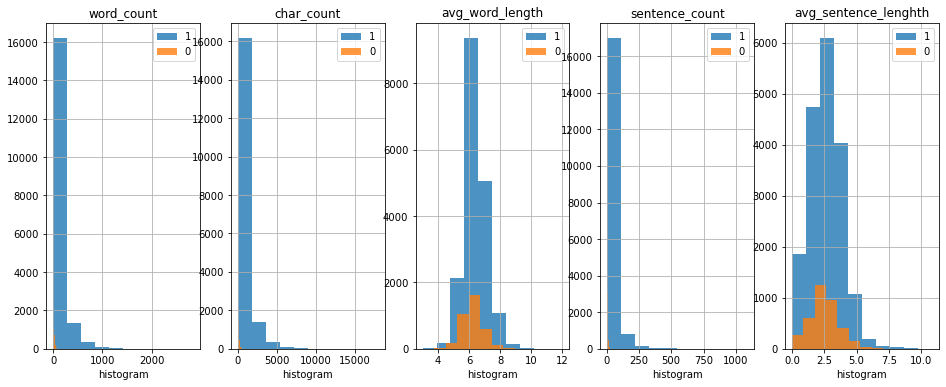

In [32]:
# visualize the distribution of the dataset
x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "company_paticipants_yes"
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
for i in model_df[y].unique():
    sns.distplot(model_df[model_df[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(model_df[model_df[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(model_df[model_df[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
    sns.distplot(model_df[model_df[y]==i][x4], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[3])
    sns.distplot(model_df[model_df[y]==i][x5], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[4])
ax[0].grid(True)
ax[0].legend(model_df[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(model_df[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(model_df[y].unique())
ax[2].set_title("avg_word_length")
ax[3].grid(True)
ax[3].legend(model_df[y].unique())
ax[3].set_title("sentence_count")
ax[4].grid(True)
ax[4].legend(model_df[y].unique())
ax[4].set_title("avg_sentence_lenghth")
plt.show()

high frequency words excluding

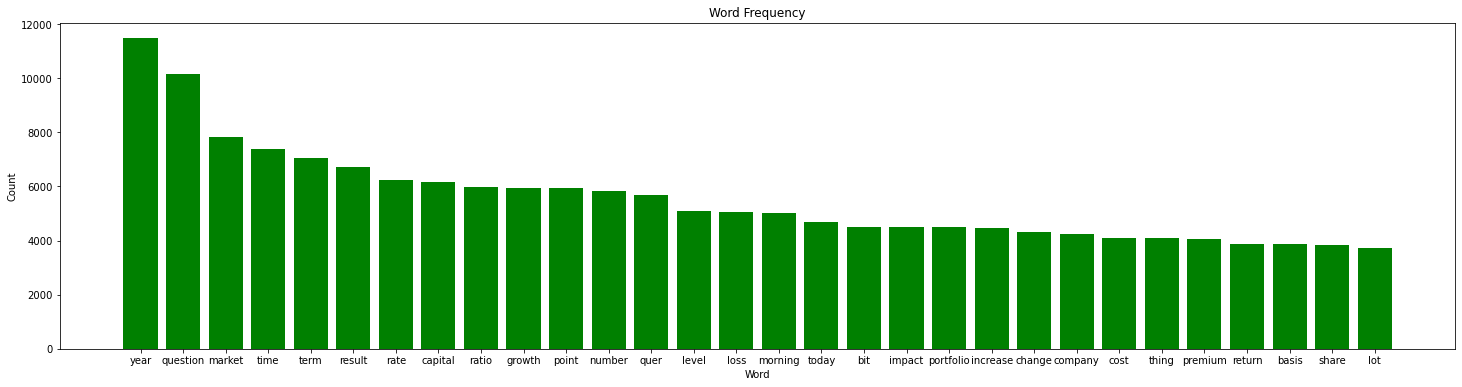

,word,freq
0,year,11483
1,question,10150
2,market,7829
3,time,7402
4,term,7036
...,...,...
8315,gping,1
8316,floodplain,1
8317,floatation,1
8318,thia,1


In [33]:
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()
word_fr

In [34]:
# remove 50 most frequent words which is known in this context
word_list = word_fr.head(50)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]

model_df['tokens'] = mdy_list

In [35]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram = Phrases(                              
    docs_tokens,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases(                             
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
# docs_phrased

In [36]:
len(docs_phrased)

21784

In [37]:
# With Tomotopy, it is necessary to wrap the preprocessed documents in a corpus-like object
# create corpus
corpus = tp.utils.Corpus()                   
for item in docs_phrased:                   
    if item != []:
        corpus.add_doc(words=item)
    else:
        corpus.add_doc(words=" ")
print(len(corpus))

21784


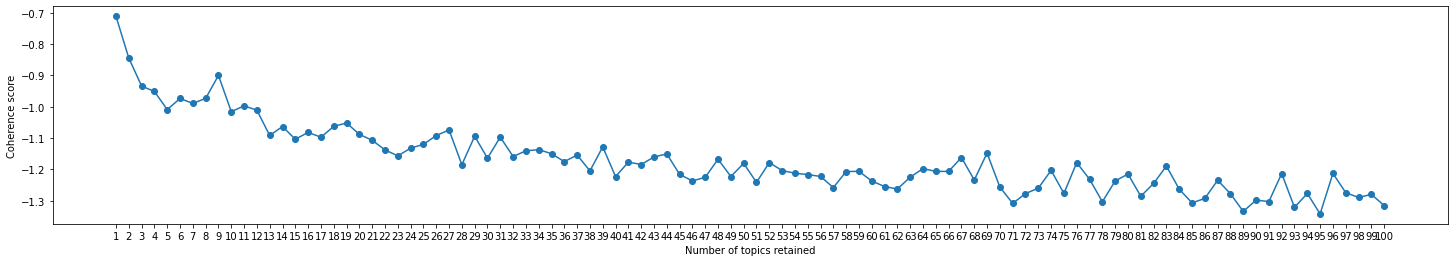

In [38]:
##### important!!! dont run this code ######

# Explore the fit of surrogate models, i.e. models that retain different numbers of topics.
cvs = {}                                    # step 1 We create an empty dictionary to store the scores of different models.
for topic_number in range(1, 101, 1):        # step 2 We let the number of retained topics vary between models, and for each model we record the associated Coherence Score
    mdl = tp.LDAModel(k=topic_number, corpus=corpus) # our over all words
    for i in range(0, 100, 10): # 100 iterations
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # lower is better

# plot the Coherence Score
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 101, 1))
plt.show()

# #1

In [52]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=95, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,mortality,0.111,0,0
1,claim,0.088,0,1
2,experience,0.067,0,2
3,provision,0.046,0,3
4,book,0.034,0,4
...,...,...,...,...
5,oﬀ,0.027,94,5
6,level,0.027,94,6
7,ﬁgure,0.027,94,7
8,ﬂow,0.026,94,8


In [53]:
import pyLDAvis
# Creating a function to prepare the data for visualisation
def topic_plot_data(best_mdl):
    topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) 
    vocab = list(best_mdl.used_vocabs)                                
    term_frequency = best_mdl.used_vocab_freq

    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data

prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

In [55]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,topic_50,topic_51,topic_52,topic_53,topic_54,topic_55,topic_56,topic_57,topic_58,topic_59,topic_60,topic_61,topic_62,topic_63,topic_64,topic_65,topic_66,topic_67,topic_68,topic_69,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79,topic_80,topic_81,topic_82,topic_83,topic_84,topic_85,topic_86,topic_87,topic_88,topic_89,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95
0,0.000113,0.000268,0.000429,0.000542,0.000083,0.000291,0.015954,0.000282,0.000186,0.000215,0.007940,0.000637,0.000408,0.000183,0.000096,0.007981,0.000588,0.000342,0.055109,0.000274,0.047237,0.125740,0.000137,0.000499,0.000395,0.000657,0.000220,0.000152,0.000317,0.000111,0.000179,0.008102,0.000209,0.000213,0.000143,0.078706,0.000164,0.086446,0.000152,0.000282,0.000246,0.023807,0.000610,0.000202,0.000607,0.000185,0.008224,0.000168,0.008147,0.000172,0.007973,0.000214,0.000325,0.000089,0.000274,0.000196,0.000512,0.000486,0.000928,0.000213,0.000085,0.000349,0.000212,0.000183,0.086643,0.000218,0.008089,0.000236,0.000083,0.008521,0.000442,0.031744,0.000603,0.000367,0.000206,0.000471,0.000244,0.000397,0.000162,0.047365,0.000214,0.000279,0.000546,0.000276,0.000265,0.000429,0.086410,0.000455,0.000380,0.000201,0.000206,0.000275,0.227563,0.000081,0.000236
1,0.000055,0.000130,0.004001,0.000262,0.000040,0.011521,0.000137,0.000137,0.000090,0.000104,0.000050,0.000308,0.000197,0.003882,0.000047,0.174566,0.098913,0.000165,0.000125,0.000133,0.000107,0.000177,0.000066,0.000241,0.000191,0.000318,0.000106,0.000074,0.216376,0.000054,0.000087,0.000129,0.000101,0.000103,0.000069,0.000168,0.000080,0.000122,0.000073,0.000136,0.000119,0.000145,0.000295,0.000098,0.000294,0.000090,0.000188,0.041808,0.000151,0.000083,0.000066,0.000104,0.034298,0.000043,0.000133,0.053202,0.000248,0.000235,0.000449,0.000103,0.011421,0.041896,0.000103,0.000089,0.000216,0.000106,0.011503,0.000114,0.000040,0.000332,0.068495,0.072268,0.000292,0.011558,0.000099,0.000228,0.000118,0.000192,0.000079,0.000169,0.000104,0.007722,0.000264,0.000134,0.000128,0.007795,0.000104,0.000220,0.000184,0.000098,0.000100,0.000133,0.117750,0.000039,0.000114
2,0.000134,0.000317,0.037678,0.037811,0.000098,0.000345,0.139718,0.000335,0.000221,0.000255,0.000123,0.000756,0.000484,0.000217,0.000114,0.000172,0.000698,0.000405,0.000306,0.000325,0.000263,0.000433,0.000162,0.000591,0.000468,0.037948,0.000260,0.000180,0.000375,0.028009,0.000212,0.000315,0.000248,0.000253,0.000169,0.000411,0.000195,0.000298,0.000180,0.000334,0.000292,0.018940,0.000723,0.000240,0.000720,0.000220,0.000460,0.000199,0.000369,0.000204,0.000163,0.000254,0.139769,0.000106,0.000325,0.000232,0.000607,0.000577,0.001101,0.000252,0.000101,0.000414,0.000252,0.176770,0.000530,0.000259,0.000301,0.000280,0.000098,0.075150,0.009817,0.000475,0.000715,0.000436,0.000244,0.000559,0.000290,0.000471,0.018777,0.000414,0.000254,0.000331,0.000648,0.000327,0.000315,0.195645,0.000255,0.000539,0.056204,0.000239,0.000244,0.000326,0.000380,0.000097,0.000280
3,0.000078,0.000186,0.000298,0.000376,0.000058,0.000202,0.000196,0.000196,0.000130,0.000149,0.000072,0.000443,0.000284,0.000127,0.000067,0.000101,0.098439,0.000237,0.000179,0.000190,0.000154,0.000254,0.000095,0.000347,0.000274,0.207409,0.000153,0.000106,0.000220,0.000077,0.000124,0.000185,0.000145,0.000148,0.000099,0.000241,0.000114,0.000174,0.000105,0.000196,0.000171,0.000208,0.000424,0.000141,0.000422,0.016467,0.000269,0.000117,0.000216,0.000119,0.000095,0.185317,0.000226,0.000062,0.049205,0.005582,0.000356,0.005784,0.000645,0.000148,0.000059,0.000243,0.000147,0.163511,0.00

In [57]:
# concat the model_df and td
model_df_df_MD95 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_df_MD95.drop(['tokens'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/topic_modelling_df_MD95.csv', index=False)

# #2

In [58]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=28, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,market,0.057,0,0
1,loss,0.054,0,1
2,cat,0.034,0,2
3,rate,0.030,0,3
4,portfolio,0.029,0,4
...,...,...,...,...
5,ratio,0.030,27,5
6,trend,0.021,27,6
7,premium,0.019,27,7
8,change,0.018,27,8


In [59]:
prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [60]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28
0,0.000757,0.032337,0.206641,0.246732,0.000915,0.000252,0.000296,0.000671,0.000640,0.000552,0.000314,0.001336,0.056119,0.016242,0.000272,0.001474,0.127585,0.000295,0.159312,0.040093,0.000397,0.000310,0.001202,0.000636,0.000218,0.000438,0.103545,0.000418
1,0.053766,0.000304,0.065114,0.343788,0.000441,0.000121,0.000143,0.000323,0.000308,0.000266,0.000151,0.000643,0.027006,0.080291,0.000131,0.000709,0.023254,0.000142,0.084296,0.000222,0.000191,0.000149,0.038723,0.000306,0.171754,0.000211,0.107046,0.000201
2,0.000900,0.000750,0.236151,0.001208,0.095283,0.000300,0.000352,0.000798,0.000761,0.000656,0.000374,0.076943,0.000754,0.226532,0.009743,0.001751,0.057426,0.000351,0.000934,0.085324,0.000472,0.000368,0.001428,0.198566,0.000259,0.000521,0.000597,0.000497
3,0.000524,0.000437,0.000386,0.000704,0.000634,0.000175,0.000205,0.110257,0.000443,0.000383,0.000218,0.000925,0.000439,0.011249,0.000188,0.001021,0.000529,0.000204,0.000544,0.538302,0.000275,0.000215,0.000832,0.104743,0.000151,0.225377,0.000348,0.000289
4,0.003796,0.003166,0.002795,0.005098,0.918656,0.001265,0.001486,0.003366,0.003210,0.002769,0.001576,0.006696,0.003181,0.001954,0.001364,0.007389,0.003833,0.001480,0.003941,0.002315,0.001990,0.001553,0.006026,0.003189,0.001091,0.002197,0.002520,0.002095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21779,0.214143,0.001060,0.000936,0.001707,0.001536,0.000424,0.000497,0.001127,0.001075,0.000927,0.000528,0.121983,0.001065,0.000654,0.000457,0.029083,0.001283,0.000495,0.001319,0.000775,0.000666,0.000520,0.002017,0.001068,0.612374,0.000735,0.000844,0.000702
21780,0.022794,0.000224,0.000198,0.000361,0.000325,0.005721,0.000105,0.000238,0.064987,0.000196,0.000112,0.006106,0.000225,0.202863,0.000097,0.000524,0.000272,0.000105,0.000279,0.002980,0.000141,0.000110,0.006058,0.000226,0.681456,0.000156,0.000179,0.002964
21781,0.002320,0.001936,0.001709,0.003117,0.002806,0.025067,0.000908,0.002058,0.001962,0.001693,0.000964,0.028388,0.001945,0.001195,0.000834,0.053105,0.002343,0.000904,0.002409,0.001415,0.001216,0.000949,0.003684,0.001950,0.850960,0.001343,0.001541,0.001281
21782,0.163095,0.014558,0.000948,0.001730,0.001557,0.000429,0.000504,0.001142,0.001089,0.000940,0.000535,0.056208,0.001079,0.000663,0.000463,0.110379,0.001300,0.000502,0.001337,0.000785,0.000675,0.000527,0.002045,0.028050,0.607147,0.000745,0.000855,0.000711


In [61]:
# concat the model_df and td
model_df_df_MD28 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_df_MD28.drop(['tokens'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/model_df_df_MD28.csv', index=False)